In [ ]:
# %pip install -U imbalanced-learn


In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dill as pickle
import xgboost as xgb
from itertools import cycle

from sklearn.preprocessing import OneHotEncoder,LabelEncoder,FunctionTransformer,LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix, RocCurveDisplay,classification_report
from imblearn.over_sampling import SMOTE


# Data Collection

In [2]:
#Read In data
df_2020 = pd.read_csv('../data/play_by_play_2020.csv',low_memory=False)
df_2021 = pd.read_csv('../data/play_by_play_2021.csv',low_memory=False)
df_2022 = pd.read_csv('../data/play_by_play_2022.csv',low_memory=False)

In [3]:
#Combine the dataframes into one
df = pd.concat([df_2020,df_2021,df_2022],axis = 0)

In [4]:
#Feature Selection
features = ['posteam','posteam_type','defteam','yardline_100','qtr','quarter_seconds_remaining','down','ydstogo','posteam_score','defteam_score','score_differential','play_type']

In [5]:
#Have the Dataframe only have the columns of selected features
df = df[features]

In [6]:
#Check
df.head()

,posteam,posteam_type,defteam,yardline_100,qtr,quarter_seconds_remaining,down,ydstogo,posteam_score,defteam_score,score_differential,play_type
0,NaN,NaN,NaN,NaN,1,900.0,NaN,0,NaN,NaN,NaN,NaN
1,SF,home,ARI,35.0,1,900.0,NaN,0,0.0,0.0,0.0,kickoff
2,SF,home,ARI,75.0,1,900.0,1.0,10,0.0,0.0,0.0,pass
3,SF,home,ARI,55.0,1,882.0,1.0,10,0.0,0.0,0.0,run
4,SF,home,ARI,41.0,1,839.0,1.0,10,0.0,0.0,0.0,run


# Data Cleaning

In [7]:
df.isnull().sum()

posteam                      11136
posteam_type                 11136
defteam                      11136
yardline_100                 12689
qtr                              0
quarter_seconds_remaining        8
down                         25931
ydstogo                          0
posteam_score                11136
defteam_score                11136
score_differential           11136
play_type                     6580
dtype: int64

In [8]:
#Since play_type is going to be our target variable, lets look into it
df[df['play_type'].isna()]

,posteam,posteam_type,defteam,yardline_100,qtr,quarter_seconds_remaining,down,ydstogo,posteam_score,defteam_score,score_differential,play_type
0,NaN,NaN,NaN,NaN,1,900.0,NaN,0,NaN,NaN,NaN,NaN
44,SF,home,ARI,NaN,1,0.0,NaN,0,10.0,7.0,3.0,NaN
76,NaN,NaN,NaN,NaN,2,120.0,NaN,0,NaN,NaN,NaN,NaN
92,NaN,NaN,NaN,NaN,2,0.0,NaN,0,NaN,NaN,NaN,NaN
134,ARI,away,SF,NaN,3,0.0,NaN,0,10.0,13.0,-3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
49900,NaN,NaN,NaN,NaN,2,0.0,NaN,0,NaN,NaN,NaN,NaN
49908,NaN,NaN,NaN,NaN,3,750.0,NaN,0,NaN,NaN,NaN,NaN
49939,SF,away,PHI,NaN,3,0.0,NaN,0,7.0,28.0,-21.0,NaN
49964,NaN,NaN,NaN,NaN,4,120.0,NaN,0,NaN,NaN,NaN,NaN


In [9]:
#It looks like the play_type is nan when its the end of a quarter, half time, 2 minute warning, or a timeout
#so it's safe to drop these rows
df.dropna(subset = 'play_type',inplace = True)

In [10]:
#Lets investigate more into our target variable
df['play_type'].value_counts()

pass           61520
run            43790
no_play        13533
kickoff         8630
punt            6470
extra_point     3961
field_goal      3192
qb_kneel        1296
qb_spike         223
Name: play_type, dtype: int64

In [11]:
#Drop where play_type is no_play
df = df[df['play_type'] != 'no_play']

In [12]:
#Check
df['play_type'].value_counts()

pass           61520
run            43790
kickoff         8630
punt            6470
extra_point     3961
field_goal      3192
qb_kneel        1296
qb_spike         223
Name: play_type, dtype: int64

In [13]:
#It looks like dropping play_type null values also dropped most of the nulls besides the down column
df.isnull().sum()

posteam                          0
posteam_type                     0
defteam                          0
yardline_100                     0
qtr                              0
quarter_seconds_remaining        0
down                         13014
ydstogo                          0
posteam_score                    0
defteam_score                    0
score_differential               0
play_type                        0
dtype: int64

In [14]:
#Check where down is null
df[df['down'].isna()]

,posteam,posteam_type,defteam,yardline_100,qtr,quarter_seconds_remaining,down,ydstogo,posteam_score,defteam_score,score_differential,play_type
1,SF,home,ARI,35.0,1,900.0,NaN,0,0.0,0.0,0.0,kickoff
8,ARI,away,SF,35.0,1,710.0,NaN,0,0.0,3.0,-3.0,kickoff
16,SF,home,ARI,15.0,1,593.0,NaN,0,9.0,0.0,9.0,extra_point
17,ARI,away,SF,35.0,1,593.0,NaN,0,0.0,10.0,-10.0,kickoff
27,ARI,away,SF,15.0,1,415.0,NaN,0,6.0,10.0,-4.0,extra_point
...,...,...,...,...,...,...,...,...,...,...,...,...
49897,SF,away,PHI,35.0,2,16.0,NaN,0,7.0,21.0,-14.0,kickoff
49901,SF,away,PHI,35.0,3,900.0,NaN,0,7.0,21.0,-14.0,kickoff
49935,PHI,home,SF,15.0,3,43.0,NaN,0,27.0,7.0,20.0,extra_point
49936,SF,away,PHI,35.0,3,43.0,NaN,0,7.0,28.0,-21.0,kickoff


In [15]:
#Drop the null values 
df.dropna(subset = 'down',inplace = True)

In [16]:
df.isnull().sum()

posteam                      0
posteam_type                 0
defteam                      0
yardline_100                 0
qtr                          0
quarter_seconds_remaining    0
down                         0
ydstogo                      0
posteam_score                0
defteam_score                0
score_differential           0
play_type                    0
dtype: int64

# Modeling

For modeling we're still going to be using xgboost but we'll be implementing the SMOTE sampling technique into our pipeline. 

In [17]:
#Create X and y
X = df.drop(columns = ['play_type','score_differential'])
y = df['play_type']

In [18]:
#Create Baseline
y.value_counts(normalize=True)

pass          0.527389
run           0.376279
punt          0.055743
field_goal    0.027501
qb_kneel      0.011166
qb_spike      0.001921
Name: play_type, dtype: float64

In [19]:
#Transform our y classes into numerical values
le = LabelEncoder()
y_sc = le.fit_transform(y)

In [20]:
#Show the classes that are being transformed in the label encoder
le.classes_

array(['field_goal', 'pass', 'punt', 'qb_kneel', 'qb_spike', 'run'],
      dtype=object)

In [21]:
#Train Test Split
X_train,X_test,y_train,y_test = train_test_split(X,y_sc,random_state = 42, stratify = y ,shuffle = True)

In [22]:
#Use ColumnTransformer to onehot encode categorical variables, used columntransformer incase use of standardscaler is necessary
processor = ColumnTransformer([
    ('ohe',OneHotEncoder(),['posteam','posteam_type','defteam'])
],remainder= 'passthrough')

In [34]:
#https://stackoverflow.com/questions/28384680/scikit-learns-pipeline-a-sparse-matrix-was-passed-but-dense-data-is-required

pipe_xgb = Pipeline([
    ('preprocess', processor),
    ('smote',SMOTE(random_state=42)),
    ('dense', FunctionTransformer(lambda x: x.todense(),accept_sparse=True)), #PCA requires todense because it comes as a sparse matrix
    ('pca', PCA()), #Principal Component Analysis
    ('xgb', xgb.XGBClassifier())
])
pipe_params = {
    'xgb__learning_rate': [0.1,0.3,1.0],
    'xgb__max_depth':[1,3,7],
    'xgb__base_score':[0.7,1.0],
    'xgb__n_estimators':[100,300]
}

In [35]:
#GridSearch over the pipeline
gs_xgb = GridSearchCV(
    pipe_xgb,
    param_grid = pipe_params,
    cv = 3
)

In [36]:
#fit the gridsearch
gs_xgb.fit(X_train,y_train)

/Users/jaysonv/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Users/jaysonv/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Users/jaysonv/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warning

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(),
                                                                         ['posteam',
                                                                          'posteam_type',
                                                                          'defteam'])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('dense',
                                        FunctionTransformer(accept_sparse=True,
                                                            func=<function <lambda> at 0x7f838e8b2040>)),
                                       ('pca', PCA()),
                                       ('xgb'

In [37]:
gs_xgb.score(X_train,y_train)

/Users/jaysonv/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


0.7460913717246211

In [38]:
gs_xgb.score(X_test,y_test)

/Users/jaysonv/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


0.5876555122859014

For accuracy on our balanced data model, we only got an increase of 6% on our accuracy.

# Model Evaluation

## Confusion Matrix

In [39]:
#Create preds to put into a confusion matrix
preds_test = gs_xgb.predict(X_test)

/Users/jaysonv/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


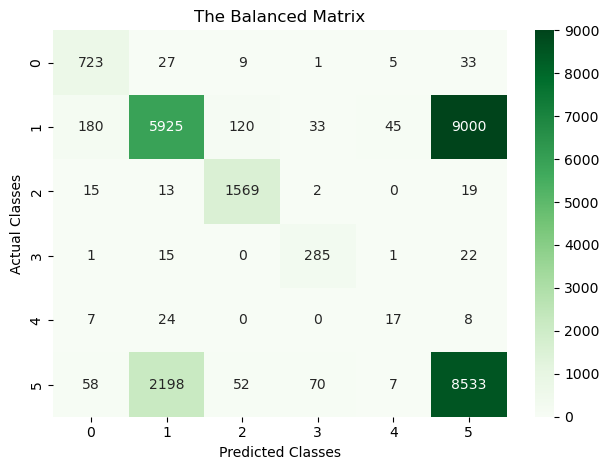

In [49]:
cm = confusion_matrix(y_test,preds_test)
sns.heatmap(cm,cmap = 'Greens',annot = True,fmt = 'g')
plt.xlabel('Predicted Classes')
plt.ylabel('Actual Classes')
plt.title('The Balanced Matrix')
plt.tight_layout()
plt.savefig('../images/edavisuals/MatrixBalanced.png')

In [41]:
print(classification_report(y_test,preds_test))

              precision    recall  f1-score   support

           0       0.73      0.91      0.81       798
           1       0.72      0.39      0.50     15303
           2       0.90      0.97      0.93      1618
           3       0.73      0.88      0.80       324
           4       0.23      0.30      0.26        56
           5       0.48      0.78      0.60     10918

    accuracy                           0.59     29017
   macro avg       0.63      0.70      0.65     29017
weighted avg       0.64      0.59      0.57     29017



However due to having more balanced data, we were able to get a higher recall on the qb spike, but in doing so we lowered the precision for the other classes and also lowered the recall for the run and pass class. Since qb spike is the least common class and we care about more accurately predicting the other classes we will use the original xgboost model as our production model.

## ROC curve

In [42]:
preds_roc_proba = gs_xgb.predict_proba(X_test)

/Users/jaysonv/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [43]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

''

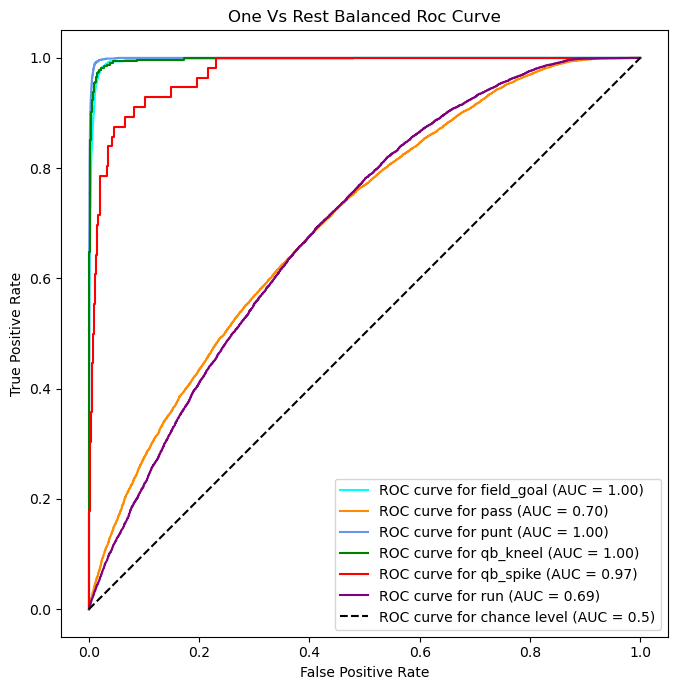

In [48]:
#Taken From Sklearns Documentation https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#multiclass-settings
fig,ax = plt.subplots(figsize = (10,7))
# Plot of a ROC curve for a specific class
colors = cycle(["aqua", "darkorange", "cornflowerblue",'green','red','purple'])
for class_id, color in zip(range(6), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        preds_roc_proba[:, class_id],
        name=f"ROC curve for {le.classes_[class_id]}",
        color=color,
        ax=ax
    )
plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One Vs Rest Balanced Roc Curve")
plt.legend()
plt.tight_layout()
plt.savefig('../images/edavisuals/OnevsRestBalanced.png')
;

The ROC curve also performs slightly worse compared to the original model, showing that by balancing the data it gave the classifier a harder time at predicting the pass and run play.